## 분석 4 : 선수단 규모 증가와 개최국 효과 사이의 관계
개최국 시 개최국 특혜로 인해 선수단 규모가 증가하는데, 메달의 총량 증가는 선수단 규모의 확장에 의한 것인가?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data.data_loader import load_olympic, load_gdp

# plt_theme
plt.style.use('dark_background')
sns.set_theme(style="darkgrid", rc={
    "axes.facecolor": "#1e1e1e",
    "grid.color": "#3c3c3c",
    "figure.facecolor": "#1e1e1e",
    "xtick.color": "white",  # x축 눈금 색상
    "ytick.color": "white",  # y축 눈금 색상
    "text.color": "white"
})
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 데이터 수집

In [2]:
# 1. host_map 정의 (개최 도시 - 국가 NOC 매핑)
host_map = {    # data_loader.py 파일의 데이터
    # 하계 올림픽
    'Athina': 'GRE',
    'Paris': 'FRA',
    'St. Louis': 'USA',
    'London': 'GBR',
    'Stockholm': 'SWE',
    'Antwerpen': 'BEL',
    'Amsterdam': 'NED',
    'Los Angeles': 'USA',
    'Berlin': 'GER',
    'Helsinki': 'FIN',
    'Melbourne': 'AUS',
    'Roma': 'ITA',
    'Tokyo': 'JPN',
    'Mexico City': 'MEX',
    'Munich': 'GER',
    'Montreal': 'CAN',
    'Moskva': 'RUS',
    'Seoul': 'KOR',
    'Barcelona': 'ESP',
    'Atlanta': 'USA',
    'Sydney': 'AUS',
    'Beijing': 'CHN',
    'Rio de Janeiro': 'BRA',

    # 동계 올림픽
    'Chamonix': 'FRA',
    'Sankt Moritz': 'SUI',
    'Lake Placid': 'USA',
    'Garmisch-Partenkirchen': 'GER',
    'Oslo': 'NOR',
    'Cortina d\'Ampezzo': 'ITA',
    'Squaw Valley': 'USA',
    'Innsbruck': 'AUT',
    'Grenoble': 'FRA',
    'Sapporo': 'JPN',
    'Sarajevo': 'YUG',
    'Calgary': 'CAN',
    'Albertville': 'FRA',
    'Lillehammer': 'NOR',
    'Nagano': 'JPN',
    'Salt Lake City': 'USA',
    'Torino': 'ITA',
    'Vancouver': 'CAN',
    'Sochi': 'RUS'
}

# 2. 데이터 로드
df = load_olympic()
#regions = pd.read_csv('./data/noc_regions.csv')

# 소스 통일을 위해 가지고 왔으나, 하단에서 필요한 데이터셋을 병합해서 만드므로 해당 부분 주석처리
# 2. NOC-Region 결합
# df = pd.merge(df, regions, on='NOC', how='left')
#
# # 3. 개최국 정보 매핑(host_country_map활용)
# df['Host_NOC'] = df['City'].map(host_country_map)
#
# # 4. 개최국 여부 (Is_Host) 생성
# # 해당 행의 NOC가 개최지 NOC와 같으면 True
# df['Is_Host'] = df['NOC'] == df['Host_NOC']

# 5. 메달 데이터 정제
# 1) NaN을 'No Medal'로 채워 시각화할 때 에러를 방지
# df['Medal'] = df['Medal'].fillna('None')
#
# # 2) 단체전 메달 중복 계산 방지
# # 동일 경기(Games), 동일 연도, 동일 종목(Event), 동일 메달인 경우 1개로 처리
# df['Medal_Won'] = df['Medal'].apply(lambda x: 1 if x != 'None' else 0)
#
# # 6. 확인 출력
# print(f"개최국 데이터(행) 수: {df['Is_Host'].sum()}건")
# print(df[['City', 'Host_NOC', 'Is_Host']].head(10))

### 데이터 집계

In [3]:
# 선수 단위의 데이터 집계를 개최연도/도시/참여국가별 단위로 집계
# 1. 선수단 규모 (ID 기반)
athlete_counts = df.groupby(['Year', 'City', 'NOC'])['ID'].nunique().reset_index(name='Athlete_Count')

# 2. 메달 수 (팀 경기 중복 제거)
medal_counts = df[df['Medal'].notna()].drop_duplicates(['Year', 'Event', 'Medal', 'NOC'])
medal_counts = medal_counts.groupby(['Year', 'City', 'NOC'])['Medal'].count().reset_index(name='Medal_Count')

# 3. 데이터 병합 (Year, City, NOC 기준)
analysis_df = pd.merge(athlete_counts, medal_counts, on=['Year', 'City', 'NOC'], how='left').fillna(0)

# 4. Is_Host 컬럼 생성 (City를 host_map에 대조하여 판별)
analysis_df['Is_Host'] = analysis_df.apply(
    lambda x: 1 if host_map.get(x['City']) == x['NOC'] else 0, axis=1
)

# 5. 결과 확인
print(analysis_df[analysis_df['Is_Host'] == 1].head(20))
len(analysis_df[analysis_df['Is_Host'] == 1])

     Year                    City  NOC  Athlete_Count  Medal_Count  Is_Host
6    1896                  Athina  GRE            102         44.0        1
23   1900                   Paris  FRA            720        102.0        1
57   1904               St. Louis  USA            524        230.0        1
70   1906                  Athina  GRE            312         35.0        1
88   1908                  London  GBR            735        143.0        1
126  1912               Stockholm  SWE            444         65.0        1
132  1920               Antwerpen  BEL            336         42.0        1
164  1924                Chamonix  FRA             43          3.0        1
193  1924                   Paris  FRA            401         40.0        1
252  1928               Amsterdam  NED            266         23.0        1
289  1928            Sankt Moritz  SUI             41          1.0        1
310  1932             Lake Placid  USA             64         12.0        1
355  1932   

50

In [4]:
# window에 있는 글꼴로 한글 폰트 설정하기
import matplotlib
import matplotlib.font_manager as fm

font_path = "C:\\Windows\\Fonts\\gulim.ttc"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)

### 시각화

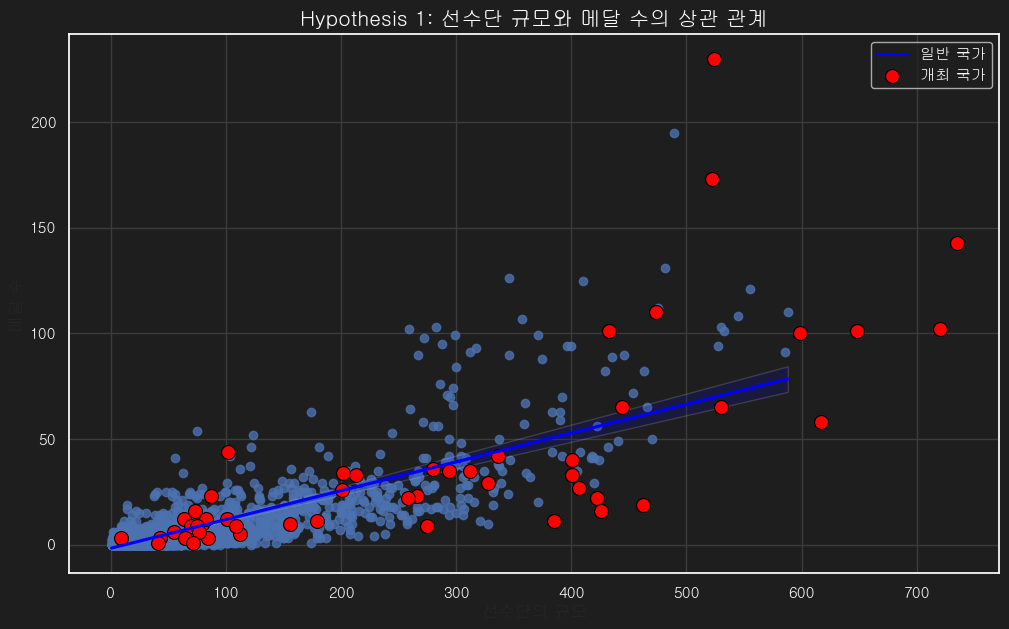

In [5]:
# 1. 팔레트 생성
plt.figure(figsize=(12, 7))

# 2. 일반 국가 데이터 (Is_Host == 0)
# X축, Y축 데이터에 대한 산점도와 회귀선을 추가한 시각도구로 regplot 선택.
sns.regplot(data=analysis_df[analysis_df['Is_Host'] == 0],
            x='Athlete_Count', y='Medal_Count',
            line_kws={'color':'blue', 'label':'일반 국가'})

# 3. 개최국 데이터 강조 (Is_Host == 1)
sns.scatterplot(data=analysis_df[analysis_df['Is_Host'] == 1],
                x='Athlete_Count', y='Medal_Count',
                color='red', s=100, label='개최 국가', edgecolor='black')

# 4. 그래프 제목 및 라벨
plt.title('Hypothesis 1: 선수단 규모와 메달 수의 상관 관계', fontsize=15)
plt.xlabel('선수단의 규모')
plt.ylabel('메달 수')
plt.legend()

plt.show()

## 결과 분석

### 선수단 규모 증가와 개최국 효과 사이의 관계
"개최국 효과란 선수단 규모 증가에 한정이 되는가"

분석:
1. 그래프의 파란색 추세선이 우상향한다. 선수단 규모와 메달 수 사이에 강력한 양의 상관관계가 있음을 알 수 있다.
2. 선수단 규모(X축)가 커질수록(오른쪽으로 갈수록) 추세선과의 간격이 더 벌어지는 경향이 보인다.
    * 일정 규모 이상의 초대형 선수단을 운영할 때는 단순한 '숫자'보다 **'종목별 집중 투자'**나 '선수 관리 역량' 같은 질적 요소가 성패를 가르는 핵심 변수가 됨을 시사합니다.


인사이트:

본 분석을 통해 본 홈 어드밴티지의 본질은 기본적으로는 '기량의 질적 도약'이 아닌 '기회의 양적 팽창'에 있다. 개최국은 대규모 선수단을 투입하여 메달 총량을 확보하는 데 성공한다. 그러나 일정 수준 이상의 대형 선수단을 도입할 때는 단순 양적 팽창 외에 다양한 요소들이 적용됨을 알 수 있다.